In [ ]:
from transformers import LlamaForCausalLM, LlamaTokenizerFast

# Load model and tokenizer
model_id = "meta-llama/Llama-3B"  # Replace with the appropriate LLaMA 3 model ID
device = "cuda:1"  # or "cpu"
model = LlamaForCausalLM.from_pretrained(model_id).to(device)
tokenizer = LlamaTokenizerFast.from_pretrained(model_id)

In [ ]:
!pip install --upgrade transformers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import torch

nltk.download('punkt')
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

# Assuming 'matches', 'dialog', 'offset', and 'perpl' are defined earlier in your code
def perplexity_to_info(dialog, tokens, perpl, answers, pattern = '<(SPK[1-9]|MOD)>'):

    matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    #encodings = tokenizer(" ".join(dialog), return_tensors="pt")
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    ppl_to_info = []
    prev_idx_pp = 0
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(r'\[([^\]]+)\]: ', '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
    
    return ppl_to_info

def filter_out_common_words(words, perpl):
    # Remove stop words and corresponding perplexity values
    filtered_words = [word for word in words if word.lower().strip() not in STOP_WORDS]
    filtered_word_indices = [i for i, word in enumerate(words) if word.lower().strip() not in STOP_WORDS]
    assert len(list(np.asarray(perpl)[filtered_word_indices])) == len(filtered_words)
    return list(np.asarray(perpl)[filtered_word_indices]), filtered_word_indices

def perplexity_to_info_filtering_out_common_words(dialog, tokens, perpl, answers, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    
    ppl_to_info = []
    prev_idx_pp = 0
    dialog_filtered = []
    for idx, (match,answer) in enumerate(zip(matches,answers)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        dialog_filtered.append(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        ppl_to_info.append({"label":answer, "perpl": np.asarray(perpl_per_sent)})
        
    return dialog_filtered, ppl_to_info

def compute_per_user_mean_perplexity_filtering_out_common_words(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):

    encodings = torch.cat(tokens)
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    prev_idx_pp = 0
    user_to_ppl = {}
    decoded_utterances = []
    for idx, match in enumerate(matches):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        label = re.sub(pattern, '', dialog[idx])
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        assert len(decoded) == len(perpl[prev_idx_pp:idx_pp])
        perpl_per_sent, filtered_word_indices = filter_out_common_words(decoded, perpl[prev_idx_pp:idx_pp])
        decoded_utterances.append([tokenizer.decode([token], skip_special_tokens=True) for token in tokens[filtered_word_indices]])
        assert len(perpl_per_sent) == len(tokens[filtered_word_indices])
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        prev_idx_pp=idx_pp
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return user_to_ppl, decoded_utterances

def compute_per_user_mean_perplexity(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    encodings = torch.cat(tokens)
    #matches = re.findall(pattern, "".join(dialog))
    unique_matches = np.unique(matches)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)


    prev_idx_pp = 0
    user_to_ppl = {}
    for idx in range(len(matches)):
        idx_pp = tokens_ids_per_sentence[idx]
        patt = matches[idx]
        tokens = encodings[prev_idx_pp:idx_pp]
        decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        mean_value=np.nanmean(np.asarray(perpl_per_sent))
        if patt not in user_to_ppl:
            user_to_ppl[patt] = []
        user_to_ppl[patt].append(mean_value)
        
    return  user_to_ppl

def create_mask(arr):
    transformed_arr = []
    for num in arr:
        if num == 0:
            transformed_arr.append(0)
        else:
            transformed_arr.extend([1] * num)
    return np.asarray(transformed_arr, dtype=np.int64).cumsum() - 1

import warnings

def compute_per_utterance_mean_perplexity(dialog, tokens, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):
    
    masked_speakers = []
    encodings = torch.cat(tokens)    
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)
    
    warnings.filterwarnings("ignore", message="Mean of empty slice")

    pos_nxt_speaker_token = np.asarray([0] + [len(tokenizer(d, return_tensors="pt").input_ids[0]) for d in dialog])
    pos_nxt_speaker_token_cumsum = pos_nxt_speaker_token.cumsum()
    bin_edges = np.concatenate([[0], tokens_ids_per_sentence])
    idx_bin = np.digitize(pos_nxt_speaker_token_cumsum, bin_edges) - 1

    assert len(idx_bin) - 1 == len(dialog)
    assert len(pos_nxt_speaker_token_cumsum) - 1 == len(dialog)

    prev_idx_pp = 0
    utterance_to_ppl = []
    current_sum = 0
    nxs_spk = []
    substring_ppl_ls = []
    utterance_to_ppl_sent = []
    
    for idx in range(len(tokens)):
        idxs_nxt_speaker_token = pos_nxt_speaker_token_cumsum[np.argwhere(np.isin(idx_bin, idx)).flatten()] - prev_idx_pp
        idx_pp = tokens_ids_per_sentence[idx]
        encodings_ = encodings[prev_idx_pp:idx_pp]
        perpl_per_sent = perpl[prev_idx_pp:idx_pp]
        substring_ppl = [np.nanmean(perpl_per_sent[start:end]) for start, end in zip([0] + list(idxs_nxt_speaker_token), list(idxs_nxt_speaker_token) + [None])]
        substrings_detoken = [encodings_[start:end] for start, end in zip([0] + list(idxs_nxt_speaker_token), list(idxs_nxt_speaker_token) + [None])] 
        substring_ppl_ls = [substring_ppl[num] for num, s in enumerate(substrings_detoken) if s.numel() != 0]
        utterance_to_ppl.append(substring_ppl_ls)     
        utterance_to_ppl_sent.append([tokenizer.decode(token, skip_special_tokens=True) for token in substrings_detoken])
        prev_idx_pp = idx_pp
        
        if len(idxs_nxt_speaker_token)>0 and len(substring_ppl_ls) != len(idxs_nxt_speaker_token):
            nxs_spk.append(0)
        nxs_spk.append(len(idxs_nxt_speaker_token))

    return  utterance_to_ppl, utterance_to_ppl_sent, create_mask(nxs_spk)
    
def compute_graph_perplexity(tokens, p1, p2, matches, pattern = '<(SPK[1-9]|MOD)>', answers=None):
    
    dialog = [tokenizer.decode(token, skip_special_tokens=True) for token in tokens]
    unique_matches = np.unique(matches)
    
    rows = int(np.ceil(np.sqrt(len(dialog))))
    # Create an 8x8 grid of subplots
    fig, axes = plt.subplots(rows, rows, figsize=(30, 30))
    num_plots = len(dialog)
    # Set smaller font size
    plt.rcParams.update({'font.size': 8})
    
    assert num_plots == len(matches)
    encodings = torch.cat(tokens)
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(p1)
    
    prev_idx_pp = 0
    for idx, ax in enumerate(axes.flatten()):
        if idx < num_plots:
            idx_pp = tokens_ids_per_sentence[idx]
            patt = matches[idx]
            tokens = encodings[prev_idx_pp:idx_pp]
            decoded = [tokenizer.decode([token], skip_special_tokens=True) for token in tokens]
            p1_per_sent = p1[prev_idx_pp:idx_pp]
            p2_per_sent = p2[prev_idx_pp:idx_pp]
            ax.plot(np.asarray(p1_per_sent), label=f'{patt} p1')
            ax.plot(np.asarray(p2_per_sent), label=f'{patt} p2', color='r')
            #mean_value=np.nanmean(np.asarray(perpl_per_sent))
            ax.axhline(p1_per_sent[0], color='g', label=f'{patt} p3')  # Fixed the color argument
            ax.set_xticks(np.arange(len(decoded)))
            ax.set_xticklabels(decoded, rotation=90)
            if answers is not None:
                ax.set_title(f'{answers[idx]}')
            ax.legend()
            prev_idx_pp=idx_pp

    # Hide any remaining empty subplots
    for ax in axes.flatten()[num_plots:]:
        ax.axis('off')
        
    plt.subplots_adjust(hspace=0.5, top=0.95)  
    plt.suptitle("Per-Word Perplexity across the Dataset", fontsize=30)
    plt.legend()
    plt.show()


KeyboardInterrupt



### Candor

In [ ]:
import numpy as np
import re
import pandas as pd

In [ ]:
candor_df = pd.read_csv("/u/sebono/conversational_dominance/data/processed/CANDOR/conversations.csv")
candor_df

In [ ]:
# load perplexity
import os
import pickle

p1_candor_path = "/u/sebono/conversational_dominance/notebooks/information_exchange_labelling/dataset_perplexity_results/CANDOR_p1"
perplexity_scores_list = []
perplexity_scores_list_p3 = []
for root, dirs, files in os.walk(p1_candor_path):
    for file in files:
        if file.endswith('.pkl'):
            file_name = file.replace("dominance_scores_","").replace(".pkl","")
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                loaded = pickle.load(f)
                perplexity_scores_list.append(loaded)

perplexity_scores_p1 = {k:v for element in perplexity_scores_list for k,v in element.items()}

In [ ]:
len(perplexity_scores_p1.keys())

In [ ]:
dominance = {}
for content, name in zip(candor_df["file_content"], candor_df["file_name"]):
    dominance[name] = {}
    pattern = '<(SPK[0-9]|MOD)>'
    matches = re.findall(pattern, "".join(content))
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
    tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
    assert len(torch.cat(tokens)) == len(perplexity_scores_p1[name])
    compute_graph_perplexity(tokens, perplexity_scores_p1[name],[np.nan for _ in range(len(perplexity_scores_p1[name]))],matches, pattern=pattern) 

In [ ]:
dominance_p1 = {}
for content, name in zip(candor_df["file_content"], candor_df["file_name"]):
    if name in perplexity_scores_p1.keys():
        print(name)
        dominance_p1[name] = {}
        pattern = '<(SPK[0-9]|MOD)>'
        matches = re.findall(pattern, "".join(content))
        content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
        content = [re.sub(pattern,">", d) for d in content]
        assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
        encodings = tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
        tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
        result = compute_per_user_mean_perplexity(content,tokens,perplexity_scores_p1[name], matches, pattern=pattern)
        for patt in result.keys():
            if patt in np.unique(matches):
                print(f"{patt}: {np.mean(result[patt])}")
                dominance_p1[name][patt] = np.mean(result[patt])

In [ ]:
dominance_p3 = {}
for content, name in zip(candor_df["file_content"], candor_df["file_name"]):
    if name in perplexity_scores_p1.keys():
        print(name)
        dominance_p3[name] = {}
        pattern = '<(SPK[0-9]|MOD)>'
        matches = re.findall(pattern, "".join(content))
        content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
        content = [re.sub(pattern,">", d) for d in content]
        assert len(perplexity_scores_p3[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
        encodings = tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.ravel()
        tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
        result = compute_per_user_mean_perplexity(content,tokens,perplexity_scores_p3[name], matches, pattern=pattern)
        for patt in result.keys():
            if patt in np.unique(matches):
                print(f"{patt}: {np.mean(result[patt])}")
                dominance_p3[name][patt] = np.mean(result[patt])

In [ ]:
from tqdm import tqdm

def create_extended_list(lst, arr):
    result = []
    prev_count = 0
    for i, count in enumerate(arr):
        result.extend([lst[i]] * (count - prev_count))
        prev_count = count
    return result

def compute_p3(dami2pc_df, perplexity_scores_p1):
    perplexity_scores_p3 = {}
    for content, name in tqdm(zip(candor_df["file_content"], candor_df["file_name"]), total=len(candor_df)):
        try:
            pattern = '<(SPK[0-9]|MOD)>'
            matches = re.findall(pattern, "".join(content))
            content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
            content = [re.sub(pattern,">", d) for d in content]
            assert len(perplexity_scores_p1[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
            tokens = [tokenizer(token, return_tensors="pt", return_offsets_mapping=True).input_ids[0] for token in content]
            assert len(torch.cat(tokens)) == len(perplexity_scores_p1[name])
            tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
            value = np.asarray([0] + list(np.asarray(perplexity_scores_p1[name])[tokens_ids_per_sentence[:-1]]))
            #tokens_value = np.asarray(torch.cat(tokens))[tokens_ids_per_sentence[:-1]]
            perplexity_scores_p3[name] = create_extended_list(value, tokens_ids_per_sentence)
            assert len(perplexity_scores_p3[name]) == tokenizer(" ".join(content), return_tensors="pt", return_offsets_mapping=True).input_ids.size(1)
        except:
            print(f'missing {name}')

    return perplexity_scores_p3

In [ ]:
perplexity_scores_p3 = compute_p3(candor_df, perplexity_scores_p1)

In [ ]:
path_folder ="/u/sebono/conversational_dominance/data/processed/CANDOR"

with open(f'{path_folder}/perplexity_scores_p1.pkl', 'rb') as file:
    perplexity_scores_p1 = pickle.load(file)
with open(f'{path_folder}/perplexity_scores_p3.pkl', 'rb') as file:
    perplexity_scores_p3 = pickle.load(file)

In [ ]:
from transformers import GPT2Tokenizer

# Initialize the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
bin_width = 1


def compute_bins(zero_pos, tokenizer, content, t_u, bin_width):
    
    len_per_token = [len(tokenizer(dialogue, return_tensors="pt").input_ids[0].detach().numpy()) for dialogue in content]
    tokens = [tokenizer(dialogue, return_tensors="pt").input_ids[0].detach().numpy() for dialogue in content]
    time_per_token = []
  
    for idx in range(len(content)):   
        if len(tokens[idx]) == 0:
            time_per_token.append(0)
        else:
            time_per_token.append(t_u[idx] / len(tokens[idx]))

    all_tokens = []
    for dialogue in content:
        all_tokens += list(tokenizer(dialogue, return_tensors="pt").input_ids[0].detach().numpy())

    all_tokens = np.asarray(all_tokens)
    assert len(all_tokens) == np.asarray(len_per_token).sum()
    assert len(len_per_token) == len(time_per_token)

    elements = [(count, value) for count, value in zip(len_per_token, time_per_token)]
    arr = sum([[val] * num for num, val in elements], [])
    data = np.asarray(arr).cumsum()

    bin_edges = np.arange(0, np.ceil(data.max()) + bin_width, bin_width)
    idx_bin = np.digitize(data, bin_edges) + int(zero_pos // bin_width)
    
    unique_bins = np.unique(idx_bin) 
    assert len(all_tokens) == len(idx_bin)
    return idx_bin 

In [ ]:
bin_width = 1

In [ ]:
def create_mask(arr):
    transformed_arr = []
    for num in arr:
        if num == 0:
            transformed_arr.append(0)
        else:
            transformed_arr.extend([1] * num)
    return np.asarray(transformed_arr, dtype=np.int64).cumsum() - 1

import warnings

def compute_per_utterance_mean_perplexity(dialog, tokens, idx_bin, perpl, matches, pattern = '<(SPK[1-9]|MOD)>'):
     
    masked_speakers = []

    encodings = torch.cat(tokens)    
    tokens_ids_per_sentence = np.cumsum([t.size(0) for t in tokens])
    assert tokens_ids_per_sentence[-1] == len(encodings)
    assert len(encodings) == len(perpl)

    pos_nxt_speaker_token = np.asarray([0] + [len(tokenizer(d, return_tensors="pt").input_ids[0]) for d in dialog])
    pos_nxt_speaker_token_cumsum = pos_nxt_speaker_token.cumsum()

    per_utterance_ppl = [perpl[pos_nxt_speaker_token_cumsum[i-1]:pos_nxt_speaker_token_cumsum[i]] if i < len(pos_nxt_speaker_token_cumsum) else perplexity_scores_p1[name][pos_nxt_speaker_token_cumsum[i]:] for i in range(1,len(pos_nxt_speaker_token_cumsum))]

    #checking everything is correct
    per_utterance_ppl_len = np.asarray([len(d) for d in per_utterance_ppl])
    per_utterance_len = pos_nxt_speaker_token[1:]
    assert all(per_utterance_ppl_len) == all(per_utterance_len)

    #creating per-utterance bin
    per_utterance_bin = [idx_bin[pos_nxt_speaker_token_cumsum[i-1]:pos_nxt_speaker_token_cumsum[i]] if i < len(pos_nxt_speaker_token_cumsum) else idx_bin[pos_nxt_speaker_token_cumsum[i]:] for i in range(1,len(pos_nxt_speaker_token_cumsum))]

    return  per_utterance_ppl, per_utterance_bin

In [ ]:
import glob 
from tqdm import tqdm

bin_width = 1

def compute_dominance_ppl(perplexity_scores):
    
    print("Computing dominance perplexity")
    directory = "/u/sebono/conversational_dominance/data/external/CANDOR/transcript_audiophile/"
    dominance_p = {}
    dominance_p_decoded_sent = {}
    list_skps_per_utterance = {}
    
    for content, name in tqdm(zip(candor_df["file_content"], candor_df["file_name"]), total=len(candor_df)):
        if name not in perplexity_scores:
            continue
              
        filepath = glob.os.path.join(directory, name) + ".csv"
        d = pd.read_csv(filepath)
        d_to_t = [d["start"][i] - d["start"][i-1] for i in range(1, len(d["start"]))]+[np.asarray(d["stop"])[-1] - np.asarray(d["start"])[-1]]
        pattern = '<(SPK[0-9]|MOD)>'
        matches = np.asarray(re.findall(pattern, "".join(content)))
        content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
        content = [re.sub(pattern,">", d) for d in content]
        assert len(content) == len(matches)
        try:
            assert len(content) == len(d_to_t)
        except:
            continue
        assert len(matches) == len(content)
        idx_bin = compute_bins(d["start"][0], tokenizer, content, d_to_t, bin_width)
        assert len(perplexity_scores[name]) == tokenizer(" ".join(content), return_tensors="pt").input_ids.size(1)
        assert len(idx_bin) == tokenizer(" ".join(content), return_tensors="pt").input_ids.size(1)
        unique_bins = np.unique(idx_bin)
        encodings = tokenizer(" ".join(content), return_tensors="pt").input_ids.ravel()
        tokens = [tokenizer(token, return_tensors="pt").input_ids[0] for token in content]
        
        per_utterance_ppl, per_utterance_bin = compute_per_utterance_mean_perplexity(content,tokens,idx_bin, perplexity_scores[name],matches)
        dominance_p[name] = {}
        list_skps_per_utterance[name] = {}
        dominance_p_decoded_sent[name] = {}
        for utterance_id in range(len(per_utterance_bin)):
            spk = matches[utterance_id]
            for token in range(len(per_utterance_bin[utterance_id])):
                if per_utterance_bin[utterance_id][token] not in dominance_p[name]:
                    list_skps_per_utterance[name][per_utterance_bin[utterance_id][token]] = []
                    dominance_p[name][per_utterance_bin[utterance_id][token]] = {}
                    dominance_p_decoded_sent[name][per_utterance_bin[utterance_id][token]] = {}
                if spk not in dominance_p[name][per_utterance_bin[utterance_id][token]]:
                    dominance_p[name][per_utterance_bin[utterance_id][token]][spk] = []
                    dominance_p_decoded_sent[name][per_utterance_bin[utterance_id][token]][spk] = []
                dominance_p[name][per_utterance_bin[utterance_id][token]][spk].append(per_utterance_ppl[utterance_id][token])
                dominance_p_decoded_sent[name][per_utterance_bin[utterance_id][token]][spk].append(tokens[utterance_id][token])
                list_skps_per_utterance[name][per_utterance_bin[utterance_id][token]].append(spk)
        for utterance_id in range(len(per_utterance_bin)):
            for token in range(len(per_utterance_bin[utterance_id])):
                for spk in dominance_p[name][per_utterance_bin[utterance_id][token]]:
                    dominance_p[name][per_utterance_bin[utterance_id][token]][spk] = np.mean(dominance_p[name][per_utterance_bin[utterance_id][token]][spk])
        
        df = pd.DataFrame.from_dict(dominance_p[name], orient='index')
        complete_index = range(0, df.index.max() + 1)
        complete_df = df.reindex(complete_index, fill_value=None)
        dominance_p[name] = complete_df.to_dict(orient='index')
        
        df_dominance_p_decoded_sent = pd.DataFrame.from_dict(dominance_p_decoded_sent[name], orient='index')
        complete_index = range(0, df_dominance_p_decoded_sent.index.max() + 1)
        complete_df_dominance_p_decoded_sent = df_dominance_p_decoded_sent.reindex(complete_index, fill_value=[torch.tensor(220)])
        dominance_p_decoded_sent[name] = complete_df_dominance_p_decoded_sent.to_dict(orient='index')
        
        assert len(list(dominance_p[name].keys())) == len(dominance_p_decoded_sent[name].keys())
        assert len(list(dominance_p[name].keys())) == per_utterance_bin[-1][-1] + 1 
        assert len(list(dominance_p[name].keys())) in range(int(np.ceil(d["stop"].tolist()[-1])) + 1 - 1, int(np.ceil(d["stop"].tolist()[-1])) + 1 + 1)

        
    return dominance_p,dominance_p_decoded_sent,list_skps_per_utterance

In [ ]:
import torch

In [ ]:
dummy_ppl_p1 = {key:perplexity_scores_p1[key]}
dummy_ppl_p3 = {key:perplexity_scores_p3[key]}

In [ ]:
key = dummy_ppl_p1.keys()

In [ ]:
dominance_p1,dominance_p_decoded_sent_p1,list_skps_per_utterance_p1 = compute_dominance_ppl(dummy_ppl_p1)

In [ ]:
dominance_p_decoded_sent_p1.keys()

In [ ]:
p1 = pd.DataFrame(dominance_p_decoded_sent_p1['dc3d0ae4-8d20-4d1d-8e0c-82c85a79b26e']).T.T.to_numpy()[0]

In [ ]:
dominance_p3,dominance_p_decoded_sent_p3,list_skps_per_utterance_p3 = compute_dominance_ppl(dummy_ppl_p3)

In [ ]:
dominance_p_decoded_sent_p1_text = {}
for key in dominance_p_decoded_sent_p1:
    dominance_p_decoded_sent_p1_text[key] = {}
    for n in dominance_p_decoded_sent_p1[key]:
        dominance_p_decoded_sent_p1_text[key][n] = {}
        for spk in dominance_p_decoded_sent_p1[key][n]:
            if spk not in dominance_p_decoded_sent_p1_text[key][n]:
                dominance_p_decoded_sent_p1_text[key][n][spk] = []
            dominance_p_decoded_sent_p1_text[key][n][spk].append(tokenizer.decode(dominance_p_decoded_sent_p1[key][n][spk], skip_special_tokens=True))

In [ ]:
path = "/u/sebono/conversational_dominance/data/processed/CANDOR/"

In [ ]:
dominance_p1,dominance_p_decoded_sent_p1 = compute_dominance_ppl(perplexity_scores_p1)
with open(f'{path}/dominance_p1.pkl', 'wb') as f:
    pickle.dump(dominance_p1, f)

In [ ]:
dominance_p3,dominance_p_decoded_sent_p3 = compute_dominance_ppl(perplexity_scores_p3)
with open(f'{path}/dominance_p3.pkl', 'wb') as f:
    pickle.dump(dominance_p3, f)

In [ ]:
with open(f'{path}/dominance_p1.pkl', 'wb') as f:
    pickle.dump(dominance_p1, f)

In [ ]:
path = "/u/sebono/conversational_dominance/data/processed/CANDOR/"
with open(f'{path}/dominance_p1.pkl', 'wb') as f:
    pickle.dump(dominance_p1, f)
with open(f'{path}/dominance_p3.pkl', 'wb') as f:
    pickle.dump(dominance_p3, f)

### Upload Annotations

In [3]:
import pandas as pd

/u/sebono/miniconda3/envs/.py311env/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device="cuda:1"
model_id="gpt2-large"

model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)
start_of_sentence = " "

/u/sebono/miniconda3/envs/.py311env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
import pickle
path = "/u/sebono/conversational_dominance/data/processed/CANDOR_gpt2-large/"
with open(f'{path}/dominance_p1.pkl', 'rb') as f:
    dominance_p1 = pickle.load(f)
with open(f'{path}/dominance_p3.pkl', 'rb') as f:
    dominance_p3 = pickle.load(f)

In [6]:
import pickle
path = "/u/sebono/conversational_dominance/data/processed/CANDOR_gpt2-large"
with open(f'{path}/list_skps_per_utterance_p1.pkl', 'rb') as f:
    list_skps_per_utterance_p1 = pickle.load(f)
with open(f'{path}/list_skps_per_utterance_p3.pkl', 'rb') as f:
    list_skps_per_utterance_p3 = pickle.load(f)

In [7]:
def speaker_ids(names):
    d_names = []
    re_names = []
    for id, re_n in enumerate(names):
        n = f"SPK{id}"
        re_names.append(re_n)
        d_names.append(n)
    return dict(zip(re_names,d_names))

import os
import pandas as pd
import numpy as np
import re
# List to hold the dataframes
dialogues = []
dialogues_ids = []
timestamps=[]
d_to_t = []
t_to_d = []
users = []
maps = {}
directory = "/u/sebono/conversational_dominance/data/external/CANDOR/transcript_audiophile/"
# Iterate over all CSV files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        d = pd.read_csv(filepath)
        utterances = d["utterance"]
        speakers = np.unique(np.asarray(d["speaker"]))
        map_names = speaker_ids(speakers)
        dialogues_ids.append(filename.replace(".csv",""))
        maps[filename.replace(".csv","")] = map_names


KeyboardInterrupt



In [ ]:
with open("/u/sebono/conversational_dominance/data/external/CANDOR/map.pkl", "wb") as file:
    pickle.dump(maps, file)

In [7]:
with open("/u/sebono/conversational_dominance/data/external/CANDOR/map.pkl", "rb") as file:
    maps_loaded = pickle.load(file)

In [8]:
maps_loaded

{'6ff82242-7aec-46d3-a7ed-a8a0b4076c75': {'5aeffc6e0ccc2e000185aa28': 'SPK0',
  '5ea714d0ba872d0cc55cdd79': 'SPK1'},
 'baf65544-754a-4969-8a8d-41fcc64e83c2': {'5c89bf9c54effd0016d7285b': 'SPK0',
  '5e25cd6e4bf0bc000cba6291': 'SPK1'},
 '4be7675a-c2e4-4535-a602-a57aefbadc3e': {'592481c14c4d6500016a1767': 'SPK0',
  '5b497448369f84000112bc43': 'SPK1'},
 'c578b93e-5320-4ea4-bfdf-90eb631bff74': {'5ee53940e704230cfe9c301f': 'SPK0',
  '5f16520a9e2ee97d266d4241': 'SPK1'},
 '9fc87799-741f-4741-9b8e-80de2b3a7149': {'5d1e5e30a043ee0019453932': 'SPK0',
  '5db3a4ad4e72fe000cfb3dc9': 'SPK1'},
 '208d0dd5-458e-4530-9a8f-ddd6b05bffca': {'5e8727fb90c37002d97ca052': 'SPK0',
  '5f14e0f456500058ee865863': 'SPK1'},
 'd9e1f5a5-e4eb-43df-910b-d9ae2befb039': {'5bf3761862e1bc0001f15cb2': 'SPK0',
  '5f3864a4596925371d23631e': 'SPK1'},
 '279b4ae4-c404-4365-b9ed-976bb688c803': {'5ec82c3f67c66a10c498ecf6': 'SPK0',
  '5f0cb89500197b14736aa784': 'SPK1'},
 '33567718-2e8d-454c-95fc-c34fa41a4068': {'592bb32c943e670001cde

In [9]:
def text_to_bin(conversation, key, list_skps_per_utterance_p1, pattern='<(SPK[0-9]|MOD)>', start_of_sentence = " "):
    
    content = list(conversation["file_content"])[0]
    content = re.sub(r'\<', r'\n<', content).split("\n")[1:]
    content = [re.sub(pattern,">", d) for d in content]
    encodings = tokenizer(f"{start_of_sentence}".join(content), return_tensors="pt", return_offsets_mapping=True)
    flat_iter = iter(list(encodings.input_ids[0].numpy()))
    result = [{k:[{item: next(flat_iter)} for item in sublist]} for k, sublist in list_skps_per_utterance_p1[key].items()]
    
    collapsed_result = {}

    for sublist in result:
        collapsed_sublist = []
        k = list(sublist.keys())[0]
        for item in list(sublist.values())[0]:
            speaker, value = list(item.keys())[0], list(item.values())[0]
            
            # If the last item in the collapsed_sublist has the same speaker, append the value
            if collapsed_sublist and speaker in collapsed_sublist[-1]:
                if isinstance(collapsed_sublist[-1][speaker], list):
                    collapsed_sublist[-1][speaker].append(value)
                else:
                    collapsed_sublist[-1][speaker] = [collapsed_sublist[-1][speaker], value]
            else:
                collapsed_sublist.append({speaker: value})
            
        collapsed_sublist_decoded = {}
        for speaker in collapsed_sublist:
            collapsed_sublist_decoded[list(speaker.keys())[0]] = tokenizer.decode(list(speaker.values())[0], skip_special_tokens=True)
        collapsed_result[k] = collapsed_sublist_decoded
   
    return collapsed_result

In [10]:
import os
import numpy as np
import glob
import pandas as pd
from tqdm import tqdm

path_annotations = "/u/sebono/conversational_dominance/data/processed/CANDOR_gpt2-large/affective_labels/"
final_df = pd.DataFrame([])
cols = ["prob_face_anger","prob_face_contempt","prob_face_disgust","prob_face_fear","prob_face_happiness","prob_face_neutral","prob_face_sadness","prob_face_surprise","smile"]

for key in tqdm(list(dominance_p3.keys())[0]):
    if key not in dominance_p1:
        continue
    annotation_file = glob.glob(os.path.join(path_annotations, key + "*.csv"))[0]
    
    df = pd.read_csv(annotation_file)
    users_id = np.unique(df["user_id"])
    filtered_df_l = pd.DataFrame([])
    
    for u_id in users_id:
        filtered_df = df[df["user_id"] == u_id][cols]
        filtered_df.columns = [f"{col}_{maps_loaded[key][u_id]}" for col in cols]
        filtered_df_l = pd.concat([filtered_df_l, filtered_df], axis = 1)
        
        p3 = pd.DataFrame(dominance_p3[key]).T[[maps_loaded[key][u_id]]].T.to_numpy()[0]
        p1 = pd.DataFrame(dominance_p1[key]).T[[maps_loaded[key][u_id]]].T.to_numpy()[0]        
        ppl_df = pd.DataFrame({f"{maps_loaded[key][u_id]}_p3": p3, f"{maps_loaded[key][u_id]}_p1": p1}).reset_index(drop=True)
        filtered_df_l = filtered_df_l[:len(ppl_df)].reset_index(drop=True)
        filtered_df_l = pd.concat([filtered_df_l, ppl_df], axis = 1)
    final_df = pd.concat([final_df, filtered_df_l], axis = 0)

# Resetting index after concatenation
final_df.reset_index(drop=True, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 179755.89it/s]


In [12]:
import os
import glob
import pandas as pd
from tqdm import tqdm
import re

path_annotations = "/u/sebono/conversational_dominance/data/processed/CANDOR_gpt2-large/affective_labels/"
final_df_l = pd.DataFrame([])
cols = ["prob_face_anger","prob_face_contempt","prob_face_disgust","prob_face_fear","prob_face_happiness","prob_face_neutral","prob_face_sadness","prob_face_surprise","smile"]
conversations = pd.read_csv("/u/sebono/conversational_dominance/data/processed/CANDOR_gpt2-large/conversations.csv")

for key in tqdm(list(dominance_p3.keys())[1:2]):
    tot_len_ppl = sum([len(list_skps_per_utterance_p1[key][k]) for k in list_skps_per_utterance_p1[key].keys()])
    
    if key not in dominance_p1:
        continue
    annotation_file = glob.glob(os.path.join(path_annotations, key + "*.csv"))[0]
    df = pd.read_csv(annotation_file)
    users_id = np.unique(df["user_id"])
    filtered_df_l = []
    reverse_map = {k:v for v,k in maps_loaded[key].items()}
    p3_u_id = pd.DataFrame(dominance_p3[key])
    p1_u_id = pd.DataFrame(dominance_p1[key])

    p3 = []
    p1 = []
    users = []
    utternaces = []
    conversation = conversations[conversations["file_name"]==key]
    list_skps_per_utterance_p1[key].update({k: [] for k in range(min(dominance_p3[key].keys()), max(dominance_p3[key].keys())) if k not in list_skps_per_utterance_p1[key]})
    nested_speakers_to_utterance = text_to_bin(conversation, key, list_skps_per_utterance_p1, pattern='<(SPK[0-9]|MOD)>', start_of_sentence = " ")
    
    assert len(nested_speakers_to_utterance) == len(list_skps_per_utterance_p1[key])
    
    d_1 = []
    d_3 = []
    annotations_final = {}
    annotations = []
    speakers = []
    utterances = []
    for time in range(min(list_skps_per_utterance_p1[key]),max(list_skps_per_utterance_p1[key])+1):
        for speaker in list_skps_per_utterance_p1[key][time]:
            if speaker not in annotations_final:
                annotations_final[speaker] = df[df["user_id"] == reverse_map[speaker]][cols].reset_index(drop=True)
            d_1.append(dominance_p1[key][time][speaker])
            d_3.append(dominance_p3[key][time][speaker])
            annotations.append(annotations_final[speaker].to_numpy()[time])
            speakers.append(speaker)
            print("time: ",time, "speaker: ", reverse_map[speaker], nested_speakers_to_utterance[time][speaker],annotations_final[speaker].to_numpy()[time] )
            utterances.append(nested_speakers_to_utterance[time][speaker])

    annotations_array = np.array(annotations)
    speakers_array = np.array(speakers).reshape(-1, 1)
    d_1_array = np.array(d_1).reshape(-1, 1)
    d_3_array = np.array(d_3).reshape(-1, 1)
    utterances_array = np.array(utterances).reshape(-1, 1)

    # Concatenate all arrays horizontally
    combined_array = np.hstack((speakers_array, annotations_array, d_1_array, d_3_array, utterances_array))
    columns = ['users'] + cols + ['p1', 'p3'] + ['text']

    # Create the DataFrame
    final_df_l = pd.DataFrame(combined_array, columns=columns).drop_duplicates()

  0%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (7808 > 1024). Running this sequence through the model will result in indexing errors
2024-09-01 01:50:33.755817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 01:50:41.422710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


time:  10 speaker:  5977e3867412f8000194e1fe > [0.01514843 0.00951683 0.00181985 0.01131947 0.00974845 0.66222751
 0.25785373 0.0323657  1.        ]
time:  15 speaker:  5977e3867412f8000194e1fe  Uh [0.0131331  0.00582199 0.00169326 0.00638966 0.00305064 0.55065024
 0.40002731 0.01923383 1.        ]
time:  21 speaker:  5977e3867412f8000194e1fe  huh [0.01312983 0.01008602 0.00118318 0.00412956 0.00431303 0.56800938
 0.38546919 0.01367982 1.        ]
time:  26 speaker:  5977e3867412f8000194e1fe  uh [0.01423588 0.0063421  0.00240791 0.01338678 0.00355012 0.56031452
 0.35672876 0.0430339  1.        ]
time:  31 speaker:  5977e3867412f8000194e1fe  huh [0.01597414 0.00766723 0.00212628 0.00393373 0.00344518 0.5510752
 0.40493916 0.0108391  1.        ]
time:  36 speaker:  5977e3867412f8000194e1fe . [0.01907037 0.00947311 0.0021564  0.00423187 0.00472658 0.61372145
 0.3223331  0.02428711 1.        ]
time:  42 speaker:  5977e3867412f8000194e1fe  Yeah [0.0248801  0.00777861 0.01022256 0.00633476 0

time:  312 speaker:  5d10d808156091001a74639e  > Yeah, I'll be yeah, [0.15186026 0.01046157 0.10939458 0.09106325 0.17163799 0.1155598
 0.30265696 0.04736562 0.        ]
time:  312 speaker:  5d10d808156091001a74639e  > Yeah, I'll be yeah, [0.15186026 0.01046157 0.10939458 0.09106325 0.17163799 0.1155598
 0.30265696 0.04736562 0.        ]
time:  313 speaker:  5d10d808156091001a74639e   [0.15157003 0.01436938 0.11520841 0.05718637 0.4326053  0.08240575
 0.12877856 0.01787622 0.        ]
time:  313 speaker:  5977e3867412f8000194e1fe  > no matter what.  [0.04360255 0.02516207 0.0240615  0.07127719 0.25092796 0.21340204
 0.1773314  0.19423532 1.        ]
time:  313 speaker:  5977e3867412f8000194e1fe  > no matter what.  [0.04360255 0.02516207 0.0240615  0.07127719 0.25092796 0.21340204
 0.1773314  0.19423532 1.        ]
time:  313 speaker:  5977e3867412f8000194e1fe  > no matter what.  [0.04360255 0.02516207 0.0240615  0.07127719 0.25092796 0.21340204
 0.1773314  0.19423532 1.        ]
time: 

time:  599 speaker:  5977e3867412f8000194e1fe  > [0.01216451 0.02135698 0.01463815 0.2453599  0.08445262 0.1546138
 0.23669287 0.2307212  1.        ]
time:  599 speaker:  5977e3867412f8000194e1fe  > [0.01216451 0.02135698 0.01463815 0.2453599  0.08445262 0.1546138
 0.23669287 0.2307212  1.        ]
time:  599 speaker:  5d10d808156091001a74639e  > yeah.  [0.11689739 0.0279227  0.02936054 0.04527088 0.07185642 0.56418045
 0.06471212 0.07979947 0.        ]
time:  599 speaker:  5d10d808156091001a74639e  > yeah.  [0.11689739 0.0279227  0.02936054 0.04527088 0.07185642 0.56418045
 0.06471212 0.07979947 0.        ]
time:  599 speaker:  5d10d808156091001a74639e  > yeah.  [0.11689739 0.0279227  0.02936054 0.04527088 0.07185642 0.56418045
 0.06471212 0.07979947 0.        ]
time:  599 speaker:  5d10d808156091001a74639e  > yeah.  [0.11689739 0.0279227  0.02936054 0.04527088 0.07185642 0.56418045
 0.06471212 0.07979947 0.        ]
time:  599 speaker:  5977e3867412f8000194e1fe  > [0.01216451 0.02135

time:  946 speaker:  5d10d808156091001a74639e  > Yeah. [0.0452754  0.00571929 0.0235955  0.01310894 0.82082778 0.05105313
 0.03323656 0.00718341 0.        ]
time:  946 speaker:  5d10d808156091001a74639e  > Yeah. [0.0452754  0.00571929 0.0235955  0.01310894 0.82082778 0.05105313
 0.03323656 0.00718341 0.        ]
time:  947 speaker:  5d10d808156091001a74639e  Yeah.  [0.05638267 0.01699132 0.03517405 0.02508616 0.71351691 0.09879381
 0.02156755 0.03248758 1.        ]
time:  947 speaker:  5d10d808156091001a74639e  Yeah.  [0.05638267 0.01699132 0.03517405 0.02508616 0.71351691 0.09879381
 0.02156755 0.03248758 1.        ]
time:  947 speaker:  5d10d808156091001a74639e  Yeah.  [0.05638267 0.01699132 0.03517405 0.02508616 0.71351691 0.09879381
 0.02156755 0.03248758 1.        ]
time:  947 speaker:  5977e3867412f8000194e1fe  > for what  [0.03195271 0.01493004 0.06197417 0.0951851  0.07417083 0.22478415
 0.26608472 0.23091828 1.        ]
time:  947 speaker:  5977e3867412f8000194e1fe  > for what

time:  1360 speaker:  5977e3867412f8000194e1fe  I got their advertising bread and [0.03751365 0.01646071 0.0636474  0.18414868 0.04954155 0.21954167
 0.14045361 0.28869273 1.        ]
time:  1360 speaker:  5977e3867412f8000194e1fe  I got their advertising bread and [0.03751365 0.01646071 0.0636474  0.18414868 0.04954155 0.21954167
 0.14045361 0.28869273 1.        ]
time:  1360 speaker:  5977e3867412f8000194e1fe  I got their advertising bread and [0.03751365 0.01646071 0.0636474  0.18414868 0.04954155 0.21954167
 0.14045361 0.28869273 1.        ]
time:  1360 speaker:  5977e3867412f8000194e1fe  I got their advertising bread and [0.03751365 0.01646071 0.0636474  0.18414868 0.04954155 0.21954167
 0.14045361 0.28869273 1.        ]
time:  1361 speaker:  5977e3867412f8000194e1fe  butter from the GOP for  [0.02326034 0.02183053 0.09782772 0.24408358 0.20184073 0.1152937
 0.08281889 0.21304451 1.        ]
time:  1361 speaker:  5977e3867412f8000194e1fe  butter from the GOP for  [0.02326034 0.021

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.67s/it]


In [43]:
'SPK0'->'5977e3867412f8000194e1fe'
'SPK1'->'5d10d808156091001a74639e'

SyntaxError: invalid syntax (102351027.py, line 1)

In [33]:
annotations_final['SPK0'].to_numpy()[52]

array([0.0168394 , 0.00418677, 0.00384183, 0.00673653, 0.00210062,
       0.48940784, 0.45375215, 0.02313486, 1.        ])

In [13]:
final_df_l.drop_duplicates(inplace=True)
final_df_l.to_csv("/u/sebono/conversational_dominance/data/processed/CANDOR_gpt2-large/trial.csv")

In [15]:
user_data['prob_face_anger']

NameError: name 'user_data' is not defined

In [ ]:
user_data['prob_face_anger'].to_numpy(dtype=np.float)

In [ ]:
user_data

In [29]:
user_data['p1'][800:900]

5604    3.1588466644287108
5618     2.808642363548279
5623     1.035049557685852
5649    0.9552986957132816
5662    0.8621659874916077
               ...        
6468     8.017548680305481
6472    0.3383941724896431
6484      3.43074142858386
6505    2.9618274718523026
6532    0.9746261164546013
Name: p1, Length: 100, dtype: object

In [30]:
user_data['p3'][800:900]

5604     1.7300912141799927
5618     0.3319450616836548
5623     0.3319450616836548
5649     0.2527662515640259
5662     0.8621659874916077
               ...         
6468    0.49357473850250244
6472    0.49357473850250244
6484    0.45734451785683633
6505      2.143735408782959
6532    0.11488273739814758
Name: p3, Length: 100, dtype: object

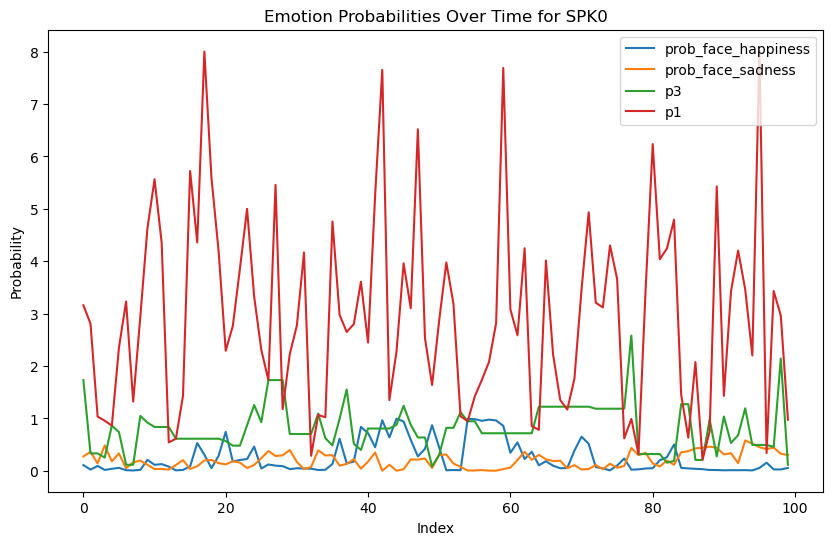

In [28]:
import matplotlib.pyplot as plt

# Assuming 'final_df_lf' is your DataFrame
emotions = ['prob_face_anger', 'prob_face_contempt', 'prob_face_disgust', 
            'prob_face_fear', 'prob_face_happiness', 'prob_face_neutral', 
            'prob_face_sadness']

# Filter data for a specific user (if needed)
user_data = final_df_l[final_df_l['users']=='SPK0']

# Plotting each emotion as a line
plt.figure(figsize=(10, 6))
#for emotion in emotions:
plt.plot(range(0, len(user_data['prob_face_happiness'][800:900])), user_data['prob_face_happiness'].to_numpy(dtype=float)[800:900], label='prob_face_happiness')
plt.plot(range(0, len(user_data['prob_face_neutral'][800:900])), user_data['prob_face_sadness'].to_numpy(dtype=float)[800:900], label='prob_face_sadness')
plt.plot(range(0, len(user_data['p3'][800:900])), user_data['p3'].to_numpy(dtype=float)[800:900], label='p3')
plt.plot(range(0, len(user_data['p1'][800:900])), user_data['p1'].to_numpy(dtype=float)[800:900], label='p1')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Probability')
plt.title('Emotion Probabilities Over Time for SPK0')
plt.legend(loc='upper right')
plt.show()


In [20]:
np.argmax(user_data['prob_face_happiness'].to_numpy(dtype=float))

844

In [21]:
user_data.iloc[830:860]

,users,prob_face_anger,prob_face_contempt,prob_face_disgust,prob_face_fear,prob_face_happiness,prob_face_neutral,prob_face_sadness,prob_face_surprise,smile,p1,p3,text
5841,SPK0,0.0129604926665446,0.0158194615505635,0.0047214008601648,0.073221682338044,0.048181954372142,0.3251109011471271,0.168375371822289,0.3516087402988757,1.0,2.772939223051071,0.701931893825531,'s nice to have those
5846,SPK0,0.0294989492123325,0.0038698324312766,0.0312706794900198,0.2598474661509196,0.0432477033386627,0.0969491792221864,0.032053861580789,0.5032623529434204,1.0,4.167782084643841,0.701931893825531,kind of exit options.
5851,SPK0,0.0576817691947023,0.0088715406289945,0.0629217792923251,0.1201205952713886,0.0408503831674655,0.1941449722896019,0.0738930641518284,0.4415158901363611,1.0,0.2862875461578369,0.701931893825531,
5868,SPK0,0.0092623396060214,0.0120547474361956,0.0063808599773507,0.0307185088212673,0.0151895868520324,0.3636381247868905,0.3915645755254305,0.1711912848628484,1.0,1.0658814907073975,1.0928795337677002,> Yeah.
5892,SPK0,0.0186176440988977,0.020277329844733,0.0101323610792557,0.0701504799226919,0.0196205622206131,0.3267972360054652,0.2932671129703522,0.2411372532447179,1.0,1.0209200382232666,0.6214931011199951,"> Yeah,"
5895,SPK0,0.0221053150172034,0.0238601759076118,0.029941718528668,0.0563790882627169,0.129743640559415,0.292991249759992,0.2974417544901371,0.1475370538731416,1.0,4.757743460791452,0.4848451954977853,"> enough, I don"
5906,SPK0,0.0029101101875615,0.0242164870724082,0.0103620866895653,0.0349479172068337,0.6116860359907149,0.0512850484655549,0.0993363370808462,0.1652559736122687,1.0,2.976321322043077,0.9911696910858154,> really
5914,SPK0,0.034084771387279,0.0250543374257783,0.0916566124030699,0.0727337359140316,0.1416559739038348,0.230876479546229,0.1311406510571638,0.272797472278277,1.0,2.6499476631482444,1.5521533489227295,have.
5920,SPK0,0.0388746075953046,0.0337907313058773,0.0413850567614038,0.0667517938961585,0.1753581136465072,0.2777563005685806,0.2206322049101193,0.1454511568881571,1.0,2.79874531351603,0.5145049026379218,> you're
5944,SPK0,0.0022211424269092,0.0420145637782601,0.0018879105530989,0.0050687687277483,0.8378127296765645,0.0395996847694429,0.0394718923605978,0.0319233225658536,1.0,3.608874313533306,0.398825079202652,"> experiencing,"


In [22]:
np.argmax(user_data['prob_face_sadness'].to_numpy(dtype=float))

893

In [115]:
user_data.iloc[890:895]

,users,prob_face_anger,prob_face_contempt,prob_face_disgust,prob_face_fear,prob_face_happiness,prob_face_neutral,prob_face_sadness,prob_face_surprise,smile,p1,p3,text
6412,SPK0,0.0273358355586727,0.0089654772231976,0.028982367614905,0.100125414536645,0.0094549464682738,0.3528734346230825,0.3137323339780172,0.15853019359832,1.0,1.430693969130516,1.035228967666626,> yeah.
6420,SPK0,0.031948539490501,0.0116945717794199,0.012644893489778,0.0268935842129091,0.0117875387892127,0.4591154972712199,0.3358902235825856,0.110025130584836,1.0,3.4206999838352203,0.53071129322052,> Should be
6429,SPK0,0.0146604068577289,0.0025401971324754,0.0188817342932452,0.3148775259032845,0.0110439543459506,0.1912238257937133,0.1449119695462286,0.301860379986465,1.0,4.204440479477246,0.6782925724983215,> interesting off season.
6453,SPK0,0.0297379046678543,0.0034056852726886,0.0869913468758265,0.208611300587654,0.0127769001449147,0.0496912660698095,0.5803268353144327,0.0284587598095337,1.0,3.459904650847117,1.1927027702331543,> How many more years
6464,SPK0,0.0271251711994409,0.002791685059977,0.1483522827426592,0.2370190352201461,0.0066787220382442,0.035565073415637,0.5177208562692006,0.0247471789518992,1.0,2.2016189098358154,0.49357473850250244,> do you have


In [117]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import plotly
import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
import seaborn as sns

In [118]:
cmp = 'algae'
def correlation_heatmap(y_cols, x_cols, full_data):
    '''
    Uses scipy.stats.spearmanr function
    Params:
    y_cols, x_cols: sets of column titles (strings)
    full_data: pandas dataframe that includes all columns listed in y_cols, x_cols
    Returns:
    corr: Spearman correlation coefficient matrix (y_cols = rows, x_cols = cols of matrix)
    fig_corr: annotated plotly heatmap of coefficients
    p: Spearman p-value matrix
    fig_p: annotated plotly heatmap of p-values
    '''
    cols = y_cols+x_cols
    all_correlations = scipy.stats.spearmanr(full_data[cols], nan_policy='omit')
    corr = all_correlations.statistic[:len(y_cols), -len(x_cols):]
    corr = pd.DataFrame(corr)
    corr.columns = x_cols
    corr.index = y_cols

    p = all_correlations.pvalue[:len(y_cols), -len(x_cols):]
    p = pd.DataFrame(p)
    p.columns = x_cols
    p.index = y_cols
    
    fig_corr = px.imshow(corr, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_r2 = px.imshow(corr**2, text_auto=True, aspect='auto', color_continuous_scale='agsunset')
    fig_p = px.imshow(p, text_auto=True, aspect='auto', color_continuous_scale='gray_r')

    return corr, fig_corr, p, fig_p, fig_r2

In [119]:
def correlation(df_final):
    corr, fig_corr, p, fig_p, fig_r2 = correlation_heatmap(col_1, col_2, df_final)
    fig_corr.show()
    fig_p.show()
    fig_r2.show()
    return corr, fig_corr, p, fig_p, fig_r2

In [120]:
# p1 - p2
#col_1 = ['prob_face_anger', 'prob_face_contempt', 'prob_face_disgust',
#       'prob_face_fear', 'prob_face_happiness', 'prob_face_neutral',
#       'prob_face_sadness', 'prob_face_surprise', 'smile',] 
col_1 = ['prob_face_happiness']
col_2 = ['p1',
         'p3']
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df_l[final_df_l["users"]=="SPK1"])

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def correlation(df):
    # Subset the DataFrame to include only the specified columns
    subset_df = df[col_1 + col_2]

    # Compute correlation matrix
    corr_matrix = subset_df.corr()

    # Compute p-values matrix
    p_values = subset_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*corr_matrix.shape)

    # Plot correlation matrix
    fig_corr, ax_corr = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax_corr)
    ax_corr.set_title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

    # Plot p-values matrix
    fig_p, ax_p = plt.subplots(figsize=(10, 8))
    sns.heatmap(p_values, annot=True, cmap='coolwarm', fmt=".2f", ax=ax_p)
    ax_p.set_title('P-Values Matrix')
    plt.tight_layout()
    plt.show()

    # Compute R-squared values
    r_squared = np.square(corr_matrix)

    return corr_matrix, fig_corr, p_values, fig_p, r_squared

# Example usage:
# corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df, col_1, col_2)


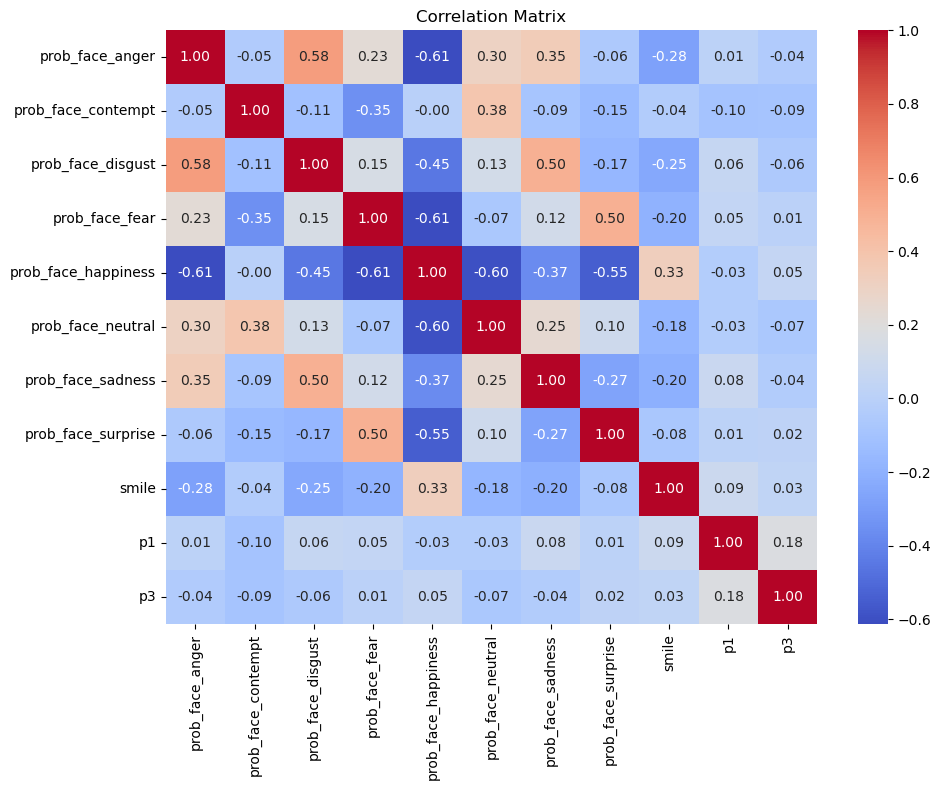

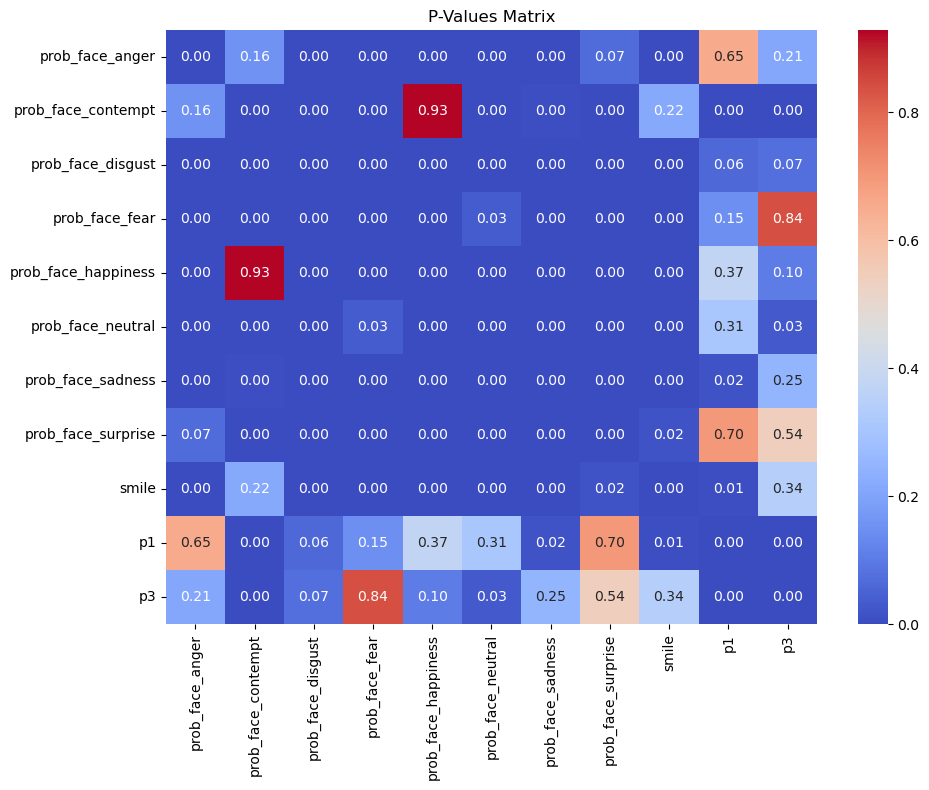

In [122]:
# p1 - p2
col_1 = ['prob_face_anger', 'prob_face_contempt', 'prob_face_disgust',
       'prob_face_fear', 'prob_face_happiness', 'prob_face_neutral',
       'prob_face_sadness', 'prob_face_surprise', 'smile',] 
col_2 = ['p1',
         'p3']
corr, fig_corr, p, fig_p, fig_r2 = correlation(final_df_l[final_df_l["users"]=="SPK1"])

### Color-code

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming final_df is your DataFrame containing the data
# Assuming col_1 contains the sentiments you want to plot
col_1 = [
    'prob_face_happiness',
    'prob_face_surprise',
]

# Assign colors to sentiments based on their polarity
colors = {

    'prob_face_happiness': 'lightgreen',
    'prob_face_surprise': 'blue',
}


# Function to calculate the interpolated color
def calculate_color(row):
    spk = list(row.keys())[0].split("_")[-1]
    sentiment_colors = [colors[sentiment] for sentiment in col_1]
    weights = [row[col_1[i]] for i in range(len(col_1))]
    weights_sum = sum(weights)
    normalized_weights = [weight / weights_sum if weights_sum != 0 else 0 for weight in weights]
    avg_color = np.average(sns.color_palette(sentiment_colors), weights=normalized_weights, axis=0)
    return avg_color

# Create a separate DataFrame for each user (SPK0 and SPK1)
data = final_df_l[[col for col in col_1]]
final_df_l['color'] = data.apply(calculate_color, axis=1)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
final_df_l

In [ ]:
col_1 = ['prob_face_anger', 'prob_face_contempt', 'prob_face_disgust',
       'prob_face_fear', 'prob_face_happiness', 'prob_face_neutral',
       'prob_face_sadness', 'prob_face_surprise', 'smile'] 

In [ ]:
final_df_l.dropna(subset=['p1', 'p3'], inplace=True)

In [ ]:
len(final_df_l[final_df_l["users"]=="SPK1"]),len(final_df_l[final_df_l["users"]=="SPK0"])

In [ ]:
# Create scatter plot
final_df_i = final_df_l[final_df_l["users"]=="SPK0"]
plt.scatter(final_df_i['p1'], final_df_i['p3'], color=final_df_i['color'])
plt.xlabel('p1')
plt.ylabel('p3')
plt.title('Scatter Plot with RGB Colors')
plt.show()

In [ ]:
final_df_l[["p1","p3","users"]]